# APPLE stock price movement prediction model (for next day and next month)

## We would like to model stock prices correctly, so as a stock buyer you can reasonably decide when to buy stocks and when to sell them to make a profit. This is where time series modelling comes in. You need good machine learning models that can look at the history of a sequence of data and correctly predict what the future elements of the sequence are going to be.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 

#### For downloading the dataset, google 'NASDAQ:AAPL' and enter the NASDAQ site. Go to 'Historical Quote' and download the dataset according to time period of you need. Here its for last 10 years. Remove the first row and sort the table ascending wise according to date.

In [2]:
df = pd.read_csv('HistoricalQuotes.csv')
df.head()

,date,close,volume,open,high,low
0,2008/10/08,12.8271,551839846,12.2733,13.7614,12.2400
1,2008/10/09,12.6771,404188521,13.3357,13.6857,12.3714
2,2008/10/10,13.8286,554729026,12.2429,14.2857,12.1429
3,2008/10/13,15.7514,384649975,14.9357,15.7900,14.4314
4,2008/10/14,14.8686,494854438,16.6086,16.6286,14.7343


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 6 columns):
date      2518 non-null object
close     2518 non-null float64
volume    2518 non-null int64
open      2518 non-null float64
high      2518 non-null float64
low       2518 non-null float64
dtypes: float64(4), int64(1), object(1)
memory usage: 118.1+ KB


In [5]:
#Changing the format of dates
df['date']= pd.to_datetime(df['date'])
#df['days']=[(df['date'][i]-df['date'][len(df['date'])-1]).days for i in range(len(df['date']))]
df.head()

,date,close,volume,open,high,low
0,2008-10-08,12.8271,551839846,12.2733,13.7614,12.2400
1,2008-10-09,12.6771,404188521,13.3357,13.6857,12.3714
2,2008-10-10,13.8286,554729026,12.2429,14.2857,12.1429
3,2008-10-13,15.7514,384649975,14.9357,15.7900,14.4314
4,2008-10-14,14.8686,494854438,16.6086,16.6286,14.7343


## Data Visualisation

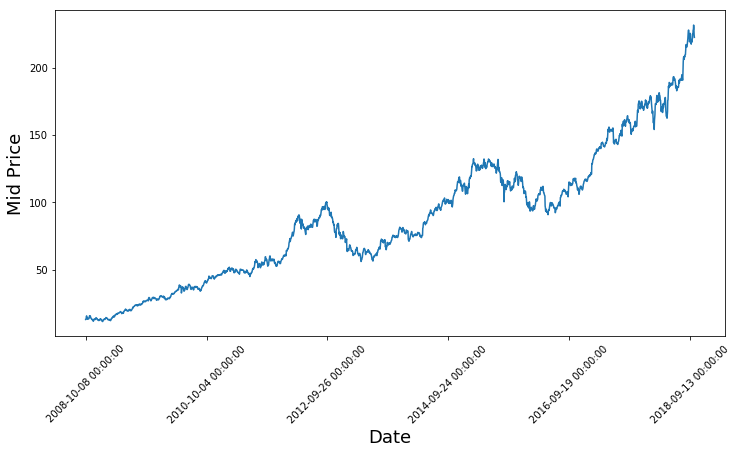

In [6]:
plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

## Data Preparation

In [7]:
#We will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day
high_prices = df.loc[:,'high'].values
low_prices = df.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0

In [8]:
#Split the training data and test data by 4:1
train_data = mid_prices[:2000]
test_data = mid_prices[2000:]

In [9]:
#Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1) #(data_size, num_features)
test_data = test_data.reshape(-1,1)

In [10]:
#Different time periods of data have different value ranges, so we normalize the data by splitting the full series into 
#windows. If we don't do this, the earlier data will be close to 0 and will not add much value to the learning process.
#Train the scaler with training data and smooth data
smoothing_window_size = 500
for i in range(0,2000,smoothing_window_size):
    scaler.fit(train_data[i: i+smoothing_window_size, :])
    train_data[i: i+smoothing_window_size, :] = scaler.transform(train_data[i: i+smoothing_window_size, :])

In [11]:
#Reshape train data back to the shape of [data_size]
train_data = train_data.reshape(-1)
#Normalize and reshape the test data
test_data = scaler.transform(test_data).reshape(-1)

In [12]:
# Now let's perform exponential moving average smoothing. So that data 
#will have a smoother curve than the origina ragged data.
EMA = 0.0
gamma= 0.1
for i in range(2000):
    EMA = gamma* train_data[i] + (1-gamma)*EMA
    train_data[i]= EMA

#Used for visualisation and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One-Step ahead Prediction via Averaging

#### Averaging mechanisms allow us to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. We will look at two averaging techniques below; standard averaging and exponential moving average. We will evaluate both qualitatively (visual inspection) and quantitatively (Mean Squared Error) the results produced by the two algorithms.The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions.

### Standard Average
`The prediction at t+1 is the average value of all the stock prices you observed within a window of t to t−N`

In [13]:
window_size=10 #for 10 days
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):
    if pred_idx > N:
        date = dt.datetime.strptime(k,'%Y-%m-%d').date()+ dt.timedelta(days=1)
    else:
        date= df.loc[pred_idx,'date']
        
    std_avg_predictions.append(np.mean(train_data[pred_idx - window_size : pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging : %.5f' %(0.5*np.mean(mse_errors)))

MSE error for standard averaging : 0.00084


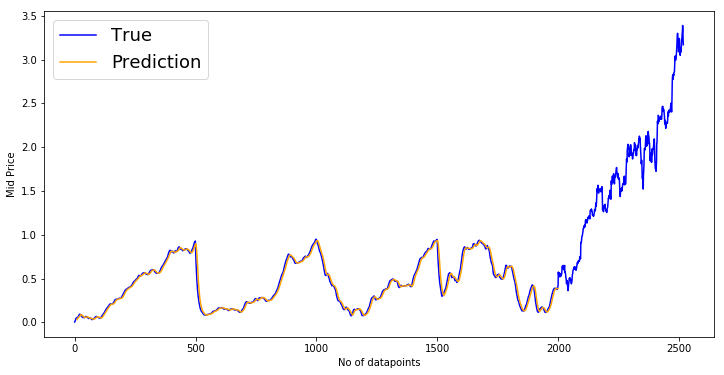

In [14]:
#Let's visualize
plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xlabel('No of datapoints')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Here Standard averaging follows the actual behavior of stock quite closely. This is not bad of a model for very short predictions (one day ahead) given that stock prices don't change from 0 to 100 overnight.

### Exponential Moving Average
`In the exponential moving average method, we calculate x_t+1 as,`
            
            `x_t+1 = EMA_t = γ * EMA_t-1 + (1-γ)*x_t`  
 
 `where EMA_0 = 0 and EMA is the exponential moving average value you maintain over time.`

The above equation basically calculates the exponential moving average from t+1 time step and uses that as the one step ahead prediction. γ decides what the contribution of the most recent prediction is to the EMA. For example, a γ=0.1 gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average.

In [15]:
window_size= 10 #for 10 days
N= train_data.size
run_avg_predictions =[]
run_avg_x = []
mse_errors=[]
running_mean= 0.0
run_avg_predictions.append(running_mean)
decay =0.5

for pred_idx in range(1,N):
    running_mean = running_mean*decay + (1.0 - decay)*train_data[pred_idx -1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)
    
print('MSE error for EMA averaging: %.5f' %(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00013


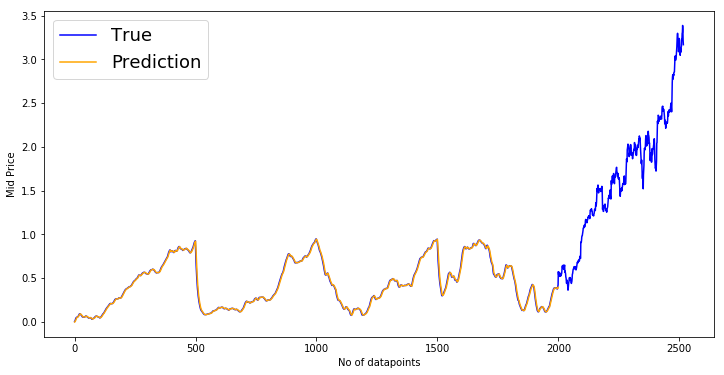

In [16]:
#Let's visualize
plt.figure(figsize = (12,6))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange',label='Prediction')
plt.xlabel('No of datapoints')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Exponential average fits perfectly the line that follow true distribution. Let's give try this for predicting for next two days window. You shall see that,
`X_t+2 = X_t+1`,
thus no matter how many steps you predict in to the future, you'll keep getting the same answer for all the future prediction steps. Thus EMA is not good for calculating more than next day stock market predictions.

## Making Stock Movement Predictions far into the Future using LSTMs

#### Long Short-Term Memory models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future.

#### Data Generator for training our model : 
 `input data: [x0,x10,x20,x30],[x1,x11,x21,x31],[x2,x12,x22,x32]`
 `output data: [x1,x11,x21,x31],[x2,x12,x22,x32],[x3,x13,x23,x33]`
#### Data Augmentation: 
Make your model robust by randomly sampling out output from the set

In [17]:
class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length//self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [0.00512523 0.8045903  0.24883841 0.08307825 0.6262966 ]

	Output: [0.03669144 0.80911267 0.24883841 0.08766878 0.6262966 ]


Unrolled index 1
	Inputs:  [0.00982956 0.80911267 0.25062796 0.08560426 0.64956343]

	Output: [0.03669144 0.8130304  0.25062796 0.09356152 0.64956343]


Unrolled index 2
	Inputs:  [0.01467457 0.81308186 0.2521603  0.08766878 0.6703592 ]

	Output: [0.03669144 0.8130304  0.25308704 0.09649334 0.7129994 ]


Unrolled index 3
	Inputs:  [0.02527412 0.8130304  0.2533356  0.09036862 0.6925291 ]

	Output: [0.02527412 0.81117636 0.2516453  0.09649334 0.7508159 ]


Unrolled index 4
	Inputs:  [0.03669144 0.8124929  0.25429264 0.09356152 0.7129994 ]

	Output: [0.04738962 0.81117636 0.25308704 0.09649334 0.79587567]


#### Hyperparameters

In [18]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 30 # Number of time steps you look into the future. Related to the backpropagation through time, used to optimize the LSTM model.
batch_size = 50 # Number of samples in a batch
num_nodes = [20,20,15] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.reset_default_graph() # This is important in case you run this multiple times

#### Input and Labels

In [19]:
# Input data.
train_inputs, train_outputs = [], []

# Unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

#### Parameters of the LSTM and Regression layer

In [20]:
lstm_cells = [
    tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.contrib.layers.xavier_initializer()
                           )
 for li in range(n_layers)]

drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
    lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
b = tf.get_variable('b',initializer=tf.random_uniform([1],-0.1,0.1))

#### Calculating LSTM output and Feeding it to the regression layer to get final prediction

In [21]:
# Create cell state and hidden state variables to maintain the state of the LSTM
c, h = [],[]
initial_state = []
for li in range(n_layers):
  c.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  h.append(tf.Variable(tf.zeros([batch_size, num_nodes[li]]), trainable=False))
  initial_state.append(tf.contrib.rnn.LSTMStateTuple(c[li], h[li]))

# Do several tensor transofmations, because the function dynamic_rnn requires the output to be of a specific format.
all_inputs = tf.concat([tf.expand_dims(t,0) for t in train_inputs],axis=0)

# all_outputs is [seq_length, batch_size, num_nodes]
all_lstm_outputs, state = tf.nn.dynamic_rnn(
    drop_multi_cell, all_inputs, initial_state=tuple(initial_state),
    time_major = True, dtype=tf.float32)

all_lstm_outputs = tf.reshape(all_lstm_outputs, [batch_size*num_unrollings,num_nodes[-1]])

all_outputs = tf.nn.xw_plus_b(all_lstm_outputs,w,b)

split_outputs = tf.split(all_outputs,num_unrollings,axis=0)

#### Loss Calculation and Optimizer

In [22]:
# When calculating the loss we need to be careful about the exact form, because we calculate
# loss of all the unrolled steps at the same time
# Therefore, take the mean error or each batch and get the sum of that over all the unrolled steps

print('Defining training Loss')
loss = 0.0
with tf.control_dependencies([tf.assign(c[li], state[li][0]) for li in range(n_layers)]+
                             [tf.assign(h[li], state[li][1]) for li in range(n_layers)]):
  for ui in range(num_unrollings):
    loss += tf.reduce_mean(0.5*(split_outputs[ui]-train_outputs[ui])**2)

print('Learning rate decay operations')
global_step = tf.Variable(0, trainable=False)
inc_gstep = tf.assign(global_step,global_step + 1)
tf_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)
tf_min_learning_rate = tf.placeholder(shape=None,dtype=tf.float32)

learning_rate = tf.maximum(
    tf.train.exponential_decay(tf_learning_rate, global_step, decay_steps=1, decay_rate=0.5, staircase=True),
    tf_min_learning_rate)

# Optimizer.
print('TF Optimization operations')
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients, v = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
optimizer = optimizer.apply_gradients(
    zip(gradients, v))

print('\tAll done')

Defining training Loss
Learning rate decay operations
TF Optimization operations
	All done


#### Prediction Related Calculations

In [23]:
print('Defining prediction related TF functions')

sample_inputs = tf.placeholder(tf.float32, shape=[1,D])

# Maintaining LSTM state for prediction stage
sample_c, sample_h, initial_sample_state = [],[],[]
for li in range(n_layers):
  sample_c.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  sample_h.append(tf.Variable(tf.zeros([1, num_nodes[li]]), trainable=False))
  initial_sample_state.append(tf.contrib.rnn.LSTMStateTuple(sample_c[li],sample_h[li]))

reset_sample_states = tf.group(*[tf.assign(sample_c[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)],
                               *[tf.assign(sample_h[li],tf.zeros([1, num_nodes[li]])) for li in range(n_layers)])

sample_outputs, sample_state = tf.nn.dynamic_rnn(multi_cell, tf.expand_dims(sample_inputs,0),
                                   initial_state=tuple(initial_sample_state),
                                   time_major = True,
                                   dtype=tf.float32)

with tf.control_dependencies([tf.assign(sample_c[li],sample_state[li][0]) for li in range(n_layers)]+
                              [tf.assign(sample_h[li],sample_state[li][1]) for li in range(n_layers)]):  
  sample_prediction = tf.nn.xw_plus_b(tf.reshape(sample_outputs,[1,-1]), w, b)

print('\tAll done')

Defining prediction related TF functions
	All done


#### Running the LSTM

In [24]:
epochs = 30
valid_summary = 1 # Interval you make test predictions

n_predict_once = 30 # Number of steps you continously predict for

train_seq_length = train_data.size # Full length of the training data

train_mse_ot = [] # Accumulate Train losses
test_mse_ot = [] # Accumulate Test loss
predictions_over_time = [] # Accumulate predictions

session = tf.InteractiveSession()

tf.global_variables_initializer().run()

# Used for decaying learning rate
loss_nondecrease_count = 0
loss_nondecrease_threshold = 2 # If the test error hasn't increased in this many steps, decrease learning rate

print('Initialized')
average_loss = 0

# Define data generator
data_gen = DataGeneratorSeq(train_data,batch_size,num_unrollings)

x_axis_seq = []

# Points you start your test predictions from
test_points_seq = np.arange(2000,2460,30).tolist()

for ep in range(epochs):       

    #Training
    for step in range(train_seq_length//batch_size):

        u_data, u_labels = data_gen.unroll_batches()

        feed_dict = {}
        for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):            
            feed_dict[train_inputs[ui]] = dat.reshape(-1,1)
            feed_dict[train_outputs[ui]] = lbl.reshape(-1,1)

        feed_dict.update({tf_learning_rate: 0.0001, tf_min_learning_rate:0.000001})

        _, l = session.run([optimizer, loss], feed_dict=feed_dict)

        average_loss += l

    #Validation
    if (ep+1) % valid_summary == 0:

      average_loss = average_loss/(valid_summary*(train_seq_length//batch_size))

      # The average loss
      if (ep+1)%valid_summary==0:
        print('Average loss at step %d: %f' % (ep+1, average_loss))

      train_mse_ot.append(average_loss)

      average_loss = 0 # reset loss

      predictions_seq = []

      mse_test_loss_seq = []

      #Updating State and Making Predicitons
      for w_i in test_points_seq:
        mse_test_loss = 0.0
        our_predictions = []

        if (ep+1)-valid_summary==0:
          # Only calculate x_axis values in the first validation epoch
          x_axis=[]

        # Feed in the recent past behavior of stock prices
        # to make predictions from that point onwards
        for tr_i in range(w_i-num_unrollings+1,w_i-1):
          current_price = all_mid_data[tr_i]
          feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)    
          _ = session.run(sample_prediction,feed_dict=feed_dict)

        feed_dict = {}

        current_price = all_mid_data[w_i-1]

        feed_dict[sample_inputs] = np.array(current_price).reshape(1,1)

        # Make predictions for this many steps
        # Each prediction uses previous prediciton as it's current input
        for pred_i in range(n_predict_once):

          pred = session.run(sample_prediction,feed_dict=feed_dict)

          our_predictions.append(np.asscalar(pred))

          feed_dict[sample_inputs] = np.asarray(pred).reshape(-1,1)

          if (ep+1)-valid_summary==0:
            # Only calculate x_axis values in the first validation epoch
            x_axis.append(w_i+pred_i)

          mse_test_loss += 0.5*(pred-all_mid_data[w_i+pred_i])**2

        session.run(reset_sample_states)

        predictions_seq.append(np.array(our_predictions))

        mse_test_loss /= n_predict_once
        mse_test_loss_seq.append(mse_test_loss)

        if (ep+1)-valid_summary==0:
          x_axis_seq.append(x_axis)

      current_test_mse = np.mean(mse_test_loss_seq)

      # Learning rate decay logic
      if len(test_mse_ot)>0 and current_test_mse > min(test_mse_ot):
          loss_nondecrease_count += 1
      else:
          loss_nondecrease_count = 0

      if loss_nondecrease_count > loss_nondecrease_threshold :
            session.run(inc_gstep)
            loss_nondecrease_count = 0
            print('\tDecreasing learning rate by 0.5')

      test_mse_ot.append(current_test_mse)
      print('\tTest MSE: %.5f'%np.mean(mse_test_loss_seq))
      predictions_over_time.append(predictions_seq)
      print('\tFinished Predictions')
session.close()

Initialized
Average loss at step 1: 2.386973
	Test MSE: 0.99341
	Finished Predictions
Average loss at step 2: 1.206672
	Test MSE: 0.56032
	Finished Predictions
Average loss at step 3: 0.447856
	Test MSE: 0.38646
	Finished Predictions
Average loss at step 4: 0.357688
	Test MSE: 0.29045
	Finished Predictions
Average loss at step 5: 0.311662
	Test MSE: 0.23567
	Finished Predictions
Average loss at step 6: 0.276885
	Test MSE: 0.19745
	Finished Predictions
Average loss at step 7: 0.266058
	Test MSE: 0.17295
	Finished Predictions
Average loss at step 8: 0.254453
	Test MSE: 0.17772
	Finished Predictions
Average loss at step 9: 0.226626
	Test MSE: 0.17300
	Finished Predictions
Average loss at step 10: 0.227091
	Test MSE: 0.14704
	Finished Predictions
Average loss at step 11: 0.214998
	Test MSE: 0.13232
	Finished Predictions
Average loss at step 12: 0.211103
	Test MSE: 0.13407
	Finished Predictions
Average loss at step 13: 0.189351
	Test MSE: 0.12331
	Finished Predictions
Average loss at step 1

#### Visualize the predictions

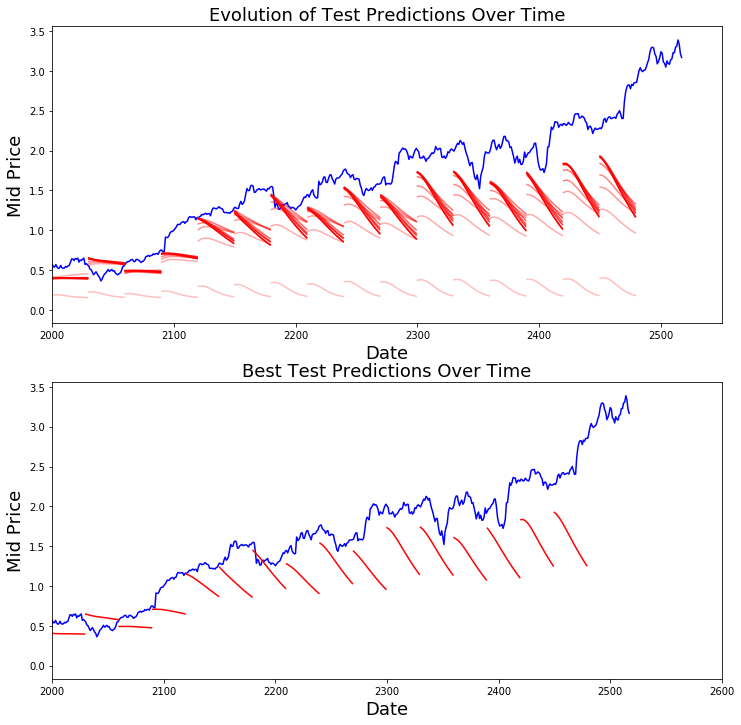

In [25]:
best_prediction_epoch = 18 # the epoch that you got the best results

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(range(df.shape[0]),all_mid_data,color='b')

# Plotting how the predictions change over time
# Plot older predictions with low alpha and newer predictions with high alpha
start_alpha = 0.25
alpha  = np.arange(start_alpha,1.1,(1.0-start_alpha)/len(predictions_over_time[::3]))
for p_i,p in enumerate(predictions_over_time[::3]):
    for xval,yval in zip(x_axis_seq,p):
        plt.plot(xval,yval,color='r',alpha=alpha[p_i])

plt.title('Evolution of Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(2000,2550)

plt.subplot(2,1,2)

# Predicting the best test prediction you got
plt.plot(range(df.shape[0]),all_mid_data,color='b')
for xval,yval in zip(x_axis_seq,predictions_over_time[best_prediction_epoch]):
    plt.plot(xval,yval,color='r')

plt.title('Best Test Predictions Over Time',fontsize=18)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.xlim(2000,2600)
plt.show()

#### We are predicting the stock price movement for next month window, not the prices themselves. In that respective, LSTM does pretty decent job.

#### Model's hyperparameters are extremely sensitive to the results obtained. So next time we shall run some hyperparameter optimization technique (Grid search / Random search) on the hyperparameters to obtain better results.